# Figure S1: Examples of inter-run and run durations modulations across all sessions performed in a given action cost condition.

## setup and imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.legend_handler import HandlerTuple

from sessionlists import (dist60, dist90, dist120, TM20, TM10, TM2, TMrev2, TMrev10, TMrev20)
from utils import *
from plotting import *
from model_functions import *

plt.style.use('./Figures/paper.mplstyle')


# color cycle
from cycler import cycler
import matplotlib as mpl
colormap = plt.get_cmap('Dark2')
mpl.rcParams['axes.prop_cycle'] = cycler(color=[colormap(k) for k in np.linspace(0, 1, 9)])

In [2]:
# Define folder with data
root = "/home/thomas/Desktop/ALLDATA"

print("Path to data is: %s"%root)
print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

# INTACT RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 
            'RatM53', 'RatM54']

Path to data is: /home/thomas/Desktop/ALLDATA
Found 34 rats in the data folder


# Block-by-block median inter-run (top) and run (bottom) durations 

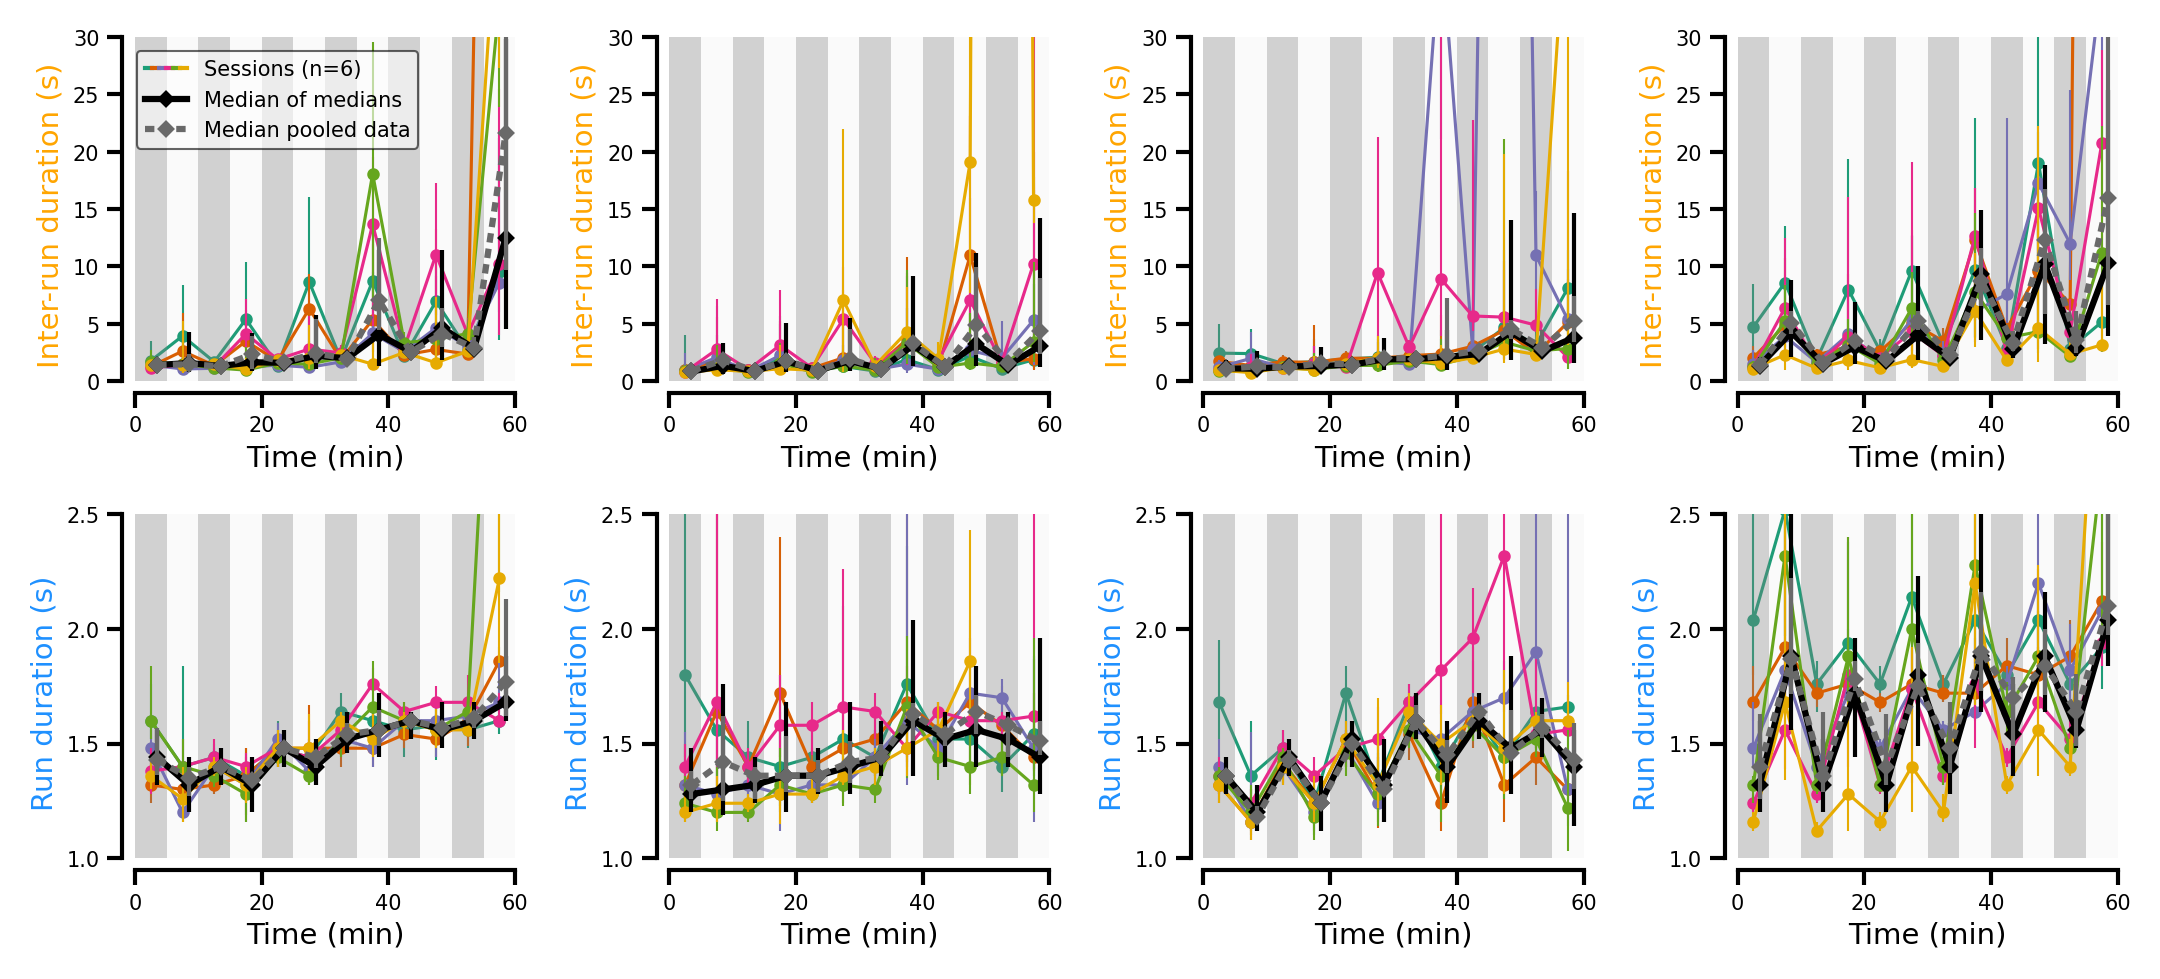

In [3]:
def _separate_data(root, animal, session_list, run_or_idle="run"):

    def fix_singleRun(data):
        recoveredRun = []
        indexList = []
        fixedList = data.copy()
        for index, ele in enumerate(data):
            if not isinstance(ele, list):
                recoveredRun.append(np.float64(ele))
                indexList.append(index)
        if indexList:
            if indexList[0] != 0:
                fixedList = np.delete(fixedList, indexList[1:])
                fixedList[indexList[0]] = recoveredRun
            if indexList[0] == 0:
                fixedList = np.delete(fixedList, indexList)
                fixedList = np.append(fixedList, recoveredRun)
        return fixedList

    data = {bin: [] for bin in range(0, (12))}

    for session in sorted(matchsession(animal, session_list)):
        if run_or_idle == "run":
            dataLeft, dataRight = get_from_pickle(root, animal, session, name="timeRun.p")
        elif run_or_idle == "idle":
            dataLeft, dataRight = get_from_pickle(root, animal, session, name="timeinZone.p")
        for i in range(12):
            data[i] = np.append(data[i], [dataRight[i] + dataLeft[i]])
            data[i] = fix_singleRun(data[i])

    return data


def median_120_run(root, animal='RatM00', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(cm2inch(5), cm2inch(5)))
    
    warnings.simplefilter("ignore", category=RuntimeWarning)
    sessionlist = dist120
    data = _separate_data(root, animal, sessionlist, run_or_idle="run")

    test = []

    for i, session in enumerate(matchsession(animal, sessionlist)):
        example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeRun.p")
        data_session = [example_runningTimeInLeftBin[i]+example_runningTimeInRightBin[i] for i in range(0, 12)]
        params = get_from_pickle(root, animal, session, name="params.p")
        blocks = params['blocks']
        rewardProbaBlock = params['rewardProbaBlock']

        session_data_medians = [np.nanmedian(data_session[i]) for i in range(12)]
        session_data_bot_percentiles = [np.nanpercentile(data_session[i], 25) for i in range(12)]
        session_data_top_percentiles = [np.nanpercentile(data_session[i], 75) for i in range(12)]
        ax.errorbar([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
                    session_data_medians,
                    yerr=[[session_data_medians[i]-session_data_bot_percentiles[i] for i in range(12)],
                          [session_data_top_percentiles[i]-session_data_medians[i] for i in range(12)]],
                    marker='o', ms=2, lw=.75, elinewidth=.5, zorder=i)
        test.append(session_data_medians)

    med = np.nanmedian(test, axis=0)
    top = np.nanpercentile(test, 75, axis=0)
    bot = np.nanpercentile(test, 25, axis=0)
    ax.errorbar([1 + (blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
                med,
                yerr=[med-bot,
                      top-med],
                capsize=0, color='dimgray', marker='D', markersize=2, linestyle=(0, (1.5, 1)), lw=1.5, elinewidth=1, zorder=25)

    data_median = [np.nanmedian(data[i], axis=0) for i in range(0, len(blocks))]
    data_bot_percentiles = [np.nanpercentile(data[i], 25) for i in range(12)]
    data_top_percentiles = [np.nanpercentile(data[i], 75) for i in range(12)]
    ax.errorbar([1+(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
                data_median,
                yerr=[[data_median[i]-data_bot_percentiles[i] for i in range(12)],
                      [data_top_percentiles[i]-data_median[i] for i in range(12)]],
                capsize=0, color='k', marker='D', markersize=2, linestyle='-', lw=1.5, elinewidth=1, zorder=15)

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)

    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Run duration (s)", color='dodgerblue')
    ax.set_xlim(0, 60)
    ax.set_ylim(1, 2.5)
    ax.set_yticks([1, 1.5, 2, 2.5])

    space_axes(ax)


def median_120_interrun(root, animal='RatM00', ax=None, leg=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(cm2inch(5), cm2inch(5)))
    
    warnings.simplefilter("ignore", category=RuntimeWarning)
    sessionlist = dist120
    data = _separate_data(root, animal, sessionlist, run_or_idle="idle")

    test = []
    for i, session in enumerate(matchsession(animal, sessionlist)):
        example_idleTimeInLeftBin, example_idleTimeInRightBin = get_from_pickle(root, animal, session, name="timeinZone.p")
        data_session = [example_idleTimeInLeftBin[i]+example_idleTimeInRightBin[i] for i in range(0, 12)]
        params = get_from_pickle(root, animal, session, name="params.p")
        blocks = params['blocks']
        rewardProbaBlock = params['rewardProbaBlock']

        session_data_medians = [np.nanmedian(data_session[i]) for i in range(12)]
        session_data_bot_percentiles = [np.nanpercentile(data_session[i], 25) for i in range(12)]
        session_data_top_percentiles = [np.nanpercentile(data_session[i], 75) for i in range(12)]
        ax.errorbar([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
                    session_data_medians,
                    yerr=[[session_data_medians[i]-session_data_bot_percentiles[i] for i in range(12)],
                          [session_data_top_percentiles[i]-session_data_medians[i] for i in range(12)]],
                    marker='o', ms=2, lw=.75, elinewidth=.5, zorder=i)
        

        test.append(session_data_medians)

    med = np.nanmedian(test, axis=0)
    top = np.nanpercentile(test, 75, axis=0)
    bot = np.nanpercentile(test, 25, axis=0)
    ax.errorbar([1 + (blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
                med,
                yerr=[med-bot,
                      top-med],
                capsize=0, color='dimgray', marker='D', markersize=2, linestyle=(0, (1.5, 1)), lw=1.5, elinewidth=1, zorder=25)

    data_median = [np.nanmedian(data[i], axis=0) for i in range(0, len(blocks))]
    data_bot_percentiles = [np.nanpercentile(data[i], 25) for i in range(12)]
    data_top_percentiles = [np.nanpercentile(data[i], 75) for i in range(12)]
    ax.errorbar([1 + (blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
                data_median,
                yerr=[[data_median[i]-data_bot_percentiles[i] for i in range(12)],
                      [data_top_percentiles[i]-data_median[i] for i in range(12)]],
                capsize=0, color='k', marker='D', markersize=2, linestyle='-', lw=1.5, elinewidth=1, zorder=15)

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)

    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Inter-run duration (s)", color='orange')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 30)

    median_of_median = ax.plot([-100, -101], [-100, -101], color='k', marker='D', markersize=2, linestyle='-', lw=1.5, label=f'Median of medians', zorder=5)
    median_of_pooled = ax.plot([-100, -101], [-100, -101], color='dimgray', marker='D', markersize=2, linestyle=(0, (1.5, 1)), lw=1.5, label=f'Median pooled data', zorder=5)

    cmap_gradients = plt.get_cmap('Dark2')(np.linspace(0, 1, 9))
    patches_cmaps_gradients = [[Line2D([0, 1], [0, 1], color=c) for c in cmap_gradients[:6]]]

    if leg:
        ax.legend(handles=[*patches_cmaps_gradients, median_of_median, median_of_pooled], 
                labels=['Sessions (n=6)', 'Median of medians', 'Median pooled data'],
                loc='upper left', bbox_to_anchor=(0.01, 0.99), 
                                frameon=True, fontsize=5, markerscale=1,
                                handler_map={list: HandlerTuple(ndivide=None, pad=0)},
                                edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

    space_axes(ax)

fig, axs = plt.subplots(2, 4, figsize=(cm2inch(18), cm2inch(8)))

median_120_interrun(root, animal='RatM00', ax=axs[0, 0], leg=True)
median_120_run(root, animal='RatM00', ax=axs[1, 0])
median_120_interrun(root, animal='RatF42', ax=axs[0, 1])
median_120_run(root, animal='RatF42', ax=axs[1, 1])
median_120_interrun(root, animal='RatM02', ax=axs[0, 2])
median_120_run(root, animal='RatM02', ax=axs[1, 2])
median_120_interrun(root, animal='RatF32', ax=axs[0, 3])
median_120_run(root, animal='RatF32', ax=axs[1, 3])


plt.savefig("./Figures_paper/Figure_S1.pdf", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

plt.savefig("./Figures_paper/Figure_S1.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)